メモ：RMSDを比較することで、良い特徴量だけを選び出す。さらに、それらの良い特徴量だけで計算を行い、全部入りの計算結果と比較して性能差がどれくらいあるか調べる。性能差がそこまで変わらず、計算時間が減ったら嬉しい。KipfらによるSpatial GCNを用いる。

In [1]:
import pandas as pd
import pickle
import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import PandasTools
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem.rdchem import HybridizationType
import rdkit.Chem.AllChem as AllChem
import torch
import torch_geometric as pyg
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch_geometric.utils import one_hot, scatter
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Dataset, InMemoryDataset, download_url, extract_zip
from torch_geometric.datasets import QM9
from torch_geometric.nn import global_add_pool
from torch_geometric.nn.conv import GCNConv
from torch_geometric.nn.models import MLP
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import one_hot, scatter
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import time
import pandas as pd
import os
import os.path as osp
import pickle
import sys
import shutil
from typing import Callable, List, Optional
import tqdm
from math import sqrt as sqrt
import backend
from backend import GCN, GCN3, MyQM9, RMSELoss, EarlyStopping, train
from sklearn.metrics import r2_score

In [ ]:
qm9csv = pd.read_csv("/home/higuchi/Pytorch/GCN/QM9/raw/gdb9.sdf.csv")
sdf = "/home/higuchi/Pytorch/GCN/QM9/raw/gdb9.sdf"
#mols = rdkit.Chem.SDMolSupplier(sdf, removeHs=False) #sdfからmolオブジェクトを生成
#mols = [m for m in mols if m is not None]
with open("mols_unprocessed", "rb") as f:
    mols = pickle.load(f)

# ETKDG Process (Mettya zikan kakaru...)
mols_ETKDG = []
mols_Hs = [rdkit.Chem.AddHs(mol) for mol in mols]
for mol in mols_Hs:
    ETKDG = AllChem.ETKDG()
    AllChem.EmbedMolecule(mol, ETKDG)
    mols_ETKDG.append(mol)

In [ ]:
# 3D structure generation with DeepChem (Hayai! approx. 2m)
import deepchem
featurizer = deepchem.feat.Mol2VecFingerprint()
mols_features = []
for mol in mols_Hs:
    features = featurizer.featurize(rdkit.Chem.MolToSmiles(mol))
    mols_features.append(features)

Setting:
layer=3, hidden_layer=64
epoch_num=100

In [17]:
#乱数ジェネレート
descriptors = ["atomic_number", "formal_charge", "valence", "degree", "aromatic", "sp", "sp2", "sp3", "num_hs"]
descriptors = ["degree", "sp3", "num_hs", "valence", "degree" "formal_charge", "aromatic", "sp", "sp2"]
target = ["mu", "alpha", "homo", "lumo", "gap", "r2", "zpve", "u0", "u298", "h298", "g298", "cv", "A", "B", "C"]
device = "cuda"

layer = 3
dim = 64
epoch_num = 200
batch_size = 32

# Check the following statement!!!

add_to_old_file = False
for pre_reduce in descriptors:
    backend.pre_reduce = pre_reduce
    try:
        shutil.rmtree("./QM9")
    except FileNotFoundError:
        pass
    dataset = MyQM9(root="./QM9", pre_reduce=pre_reduce)
    print(dataset[0].x)
    num_train = int(len(dataset)*0.8)
    num_val = len(dataset) - num_train

    for target_idx in range(len(target)):
        target_name = target[target_idx]
        if pre_reduce:
            filepath = f"./results/honban/{target_name}/GCN_without_{pre_reduce}"
        else:
            filepath = f"./results/honban/{target_name}/GCN_all"
        if os.path.isfile(filepath):
            continue
        else:
            print(f"{target_name}_{pre_reduce}")
        # 乱数の固定
        for i in range(1):
            train_set, valid_set = random_split(dataset, [num_train, num_val])
            #Dataloaderの生成
            train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
            valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

            if os.path.isfile(filepath):
                with open(filepath, "rb") as f:
                    results_dict_old = pickle.load(f)
                    results_old = results_dict_old["results"]
                    initial_epoch_num = int(results_old[-1]["Epoch"])
                    time_old = results_dict_old["time"]
            else:
                initial_epoch_num = 0
            
            model = GCN3(dataset=dataset).to(device)
            # Optimizerの初期化
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
            old_file_exists = False
            if os.path.isfile(filepath + "_model"):
                old_file_exists = True
                if add_to_old_file:
                    model.load_state_dict(torch.load(filepath + "_model"))
                    print("loaded old model")
            else:
                print("using brand new model")

            start = time.time()
            print(initial_epoch_num)
            results = train(dataset=dataset, model=model, train_loader=train_loader, valid_loader=valid_loader, optimizer=optimizer, target_idx=target_idx, initial_epoch_num=initial_epoch_num, early_stopping=None, epoch_num=epoch_num) #RMSE
            end = time.time()
            diff = end - start

            if old_file_exists:
                results = results_old + results
                diff += time_old
            
            results_dict = {"results":results, "time":diff}
            
            with open(filepath, "wb") as f:
                pickle.dump(results_dict, f)
            torch.save(model.state_dict(), filepath + "_model")

Processing...
100%|██████████| 133885/133885 [00:39<00:00, 3367.73it/s]
Done!


tensor([[0., 4., 4., 0., 0., 0., 1., 4.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.]])
lumo_atomic_number
using brand new model
0
Epoch 1 | train_loss:0.004874605465081547, valid_loss:0.0031285750683480054, train_R2:-12.459376453347021, valid_R2:0.8440581490962591
Epoch 2 | train_loss:0.0030205231903460148, valid_loss:0.003949651540819987, train_R2:0.852994604932327, valid_R2:0.7512369316724014
Epoch 3 | train_loss:0.0028834944703186025, valid_loss:0.0033565049785079246, train_R2:0.8661490263735652, valid_R2:0.823373126744463
Epoch 4 | train_loss:0.0029283303802038955, valid_loss:0.002575604731744706, train_R2:0.8610594133232694, valid_R2:0.8937734483885765
Epoch 5 | train_loss:0.002867380222710702, valid_loss:0.0030833656075723572, train_R2:0.8669500359313747, valid_R2:0.8503228100153853
Epoch 6 | train_loss:0.0027837836552563086, valid_loss:0.0025210110881734313

KeyboardInterrupt: 

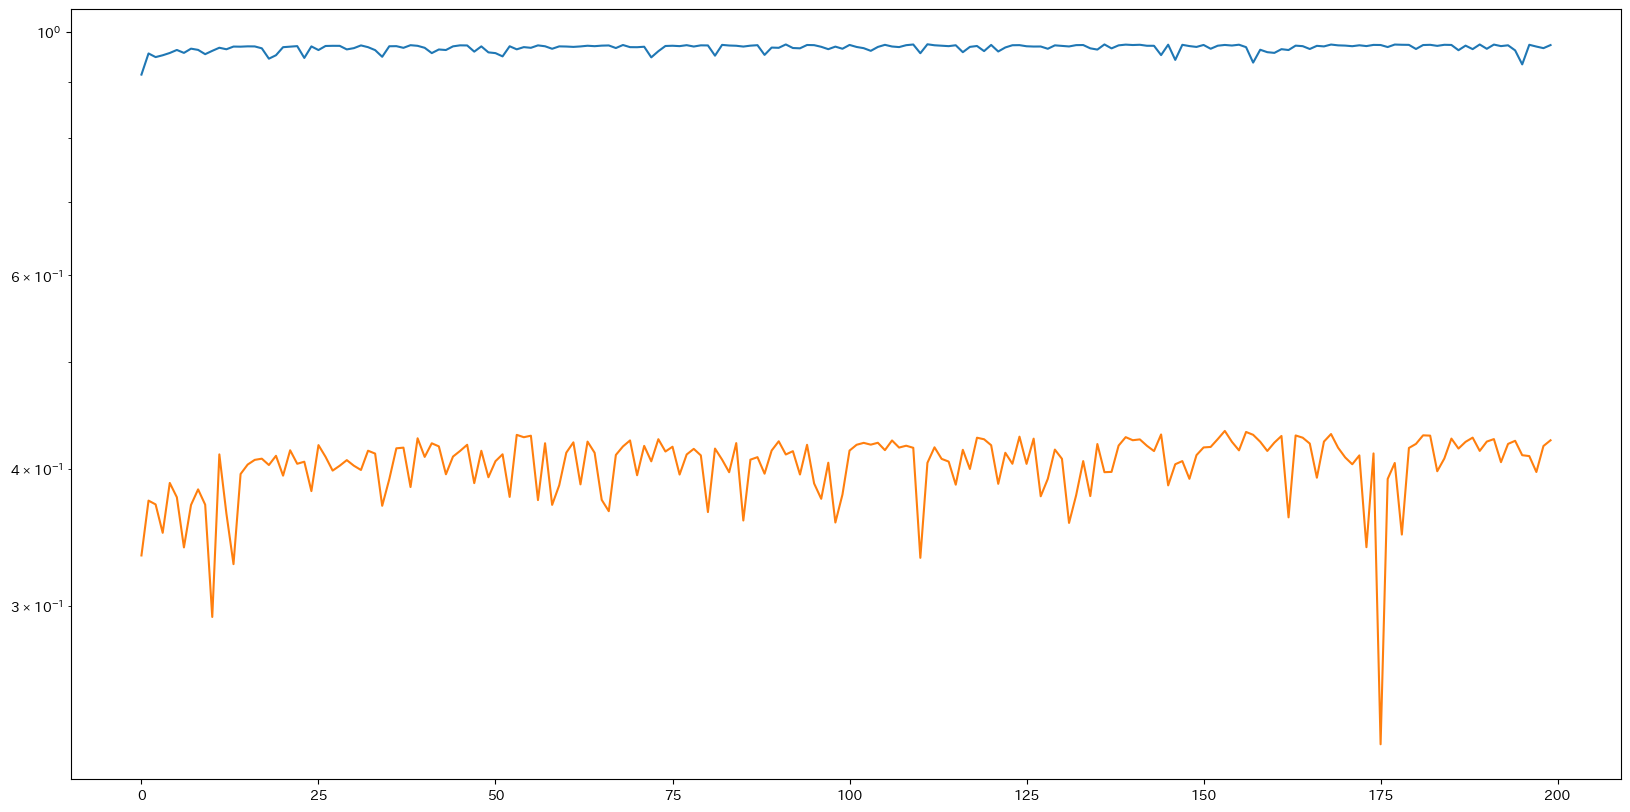

In [18]:
plt.figure(figsize=(20,10))
with open("./results/honban/alpha/GCN_without_atomic_number", "rb") as f:
    R2_alpha_atomicnum = [r["valid_R2"] for r in pickle.load(f)["results"]]
with open("./results/honban/mu/GCN_without_atomic_number", "rb") as f:
    R2_mu_atomicnum = [r["valid_R2"] for r in pickle.load(f)["results"]]
plt.plot(R2_alpha_atomicnum)
plt.plot(R2_mu_atomicnum)
plt.yscale("log")


In [19]:
import glob
def plot_train(filepath):
    filename = os.path.basename(filepath)
    with open(filepath, "rb") as f:
        result = pickle.load(f)
    plt.plot([i["train_loss"] for i in result["results"]], label=f"training_{filename}")

def plot_valid(filepath):
    filename = os.path.basename(filepath)
    with open(filepath, "rb") as f:
        result = pickle.load(f)
    plt.plot([i["valid_loss"] for i in result["results"]], label=f"valid_{filename}")

def plot_train_errorbar(filepath, label=None):
    files = glob.glob(f"{filepath}_*")
    result_list = []
    for file in files:
        with open(file, "rb") as f:
            result = pickle.load(f)
            result = [i["train_loss"] for i in result["results"]]
        result_list.append(result)
    result_avg = np.mean(result_list, axis=0)
    result_error_upper = [max([result[i] for result in result_list]) - result_avg[i] for i in range(len(result_avg))]
    result_error_lower = [abs(min([result[i] for result in result_list]) - result_avg[i]) for i in range(len(result_avg))]
    plt.errorbar(x=[i for i in range(len(result_avg))] , y=result_avg, yerr=[result_error_upper, result_error_lower ])
    plt.plot(result_avg, label=label)

def plot_valid_errorbar(filepath):
    files = glob.glob(f"{filepath}_*")
    result_list = []
    for file in files:
        with open(file, "rb") as f:
            result = pickle.load(f)
            result = [i["valid_loss"] for i in result["results"]]
        result_list.append(result)
    result_avg = np.mean(result_list, axis=0)
    result_error_upper = [max([result[i] for result in result_list]) - result_avg[i] for i in range(len(result_avg))]
    result_error_lower = [abs(min([result[i] for result in result_list]) - result_avg[i]) for i in range(len(result_avg))]
    plt.errorbar(result_avg, yerr=[result_error_upper, result_error_lower])

In [23]:
with open("./results/GCN_all", "rb") as f:
    result_all = pickle.load(f)

with open("./results/GCN_without_atomic_number", "rb") as f:
    result_atomic_number = pickle.load(f)

with open("./results/GCN_without_aromatic", "rb") as f:
    result_aromatic = pickle.load(f)

with open("./results/GCN_without_sp", "rb") as f:
    result_sp = pickle.load(f)

with open("./results/GCN_without_sp2", "rb") as f:
    result_sp2 = pickle.load(f)

with open("./results/GCN_without_sp3", "rb") as f:
    result_sp3 = pickle.load(f)

with open("./results/GCN_without_num_hs", "rb") as f:
    result_sp3 = pickle.load(f)

with open("./results/GCN_without_num_hs", "rb") as f:
    result_num_hs = pickle.load(f)



FileNotFoundError: [Errno 2] No such file or directory: './results/GCN_all'

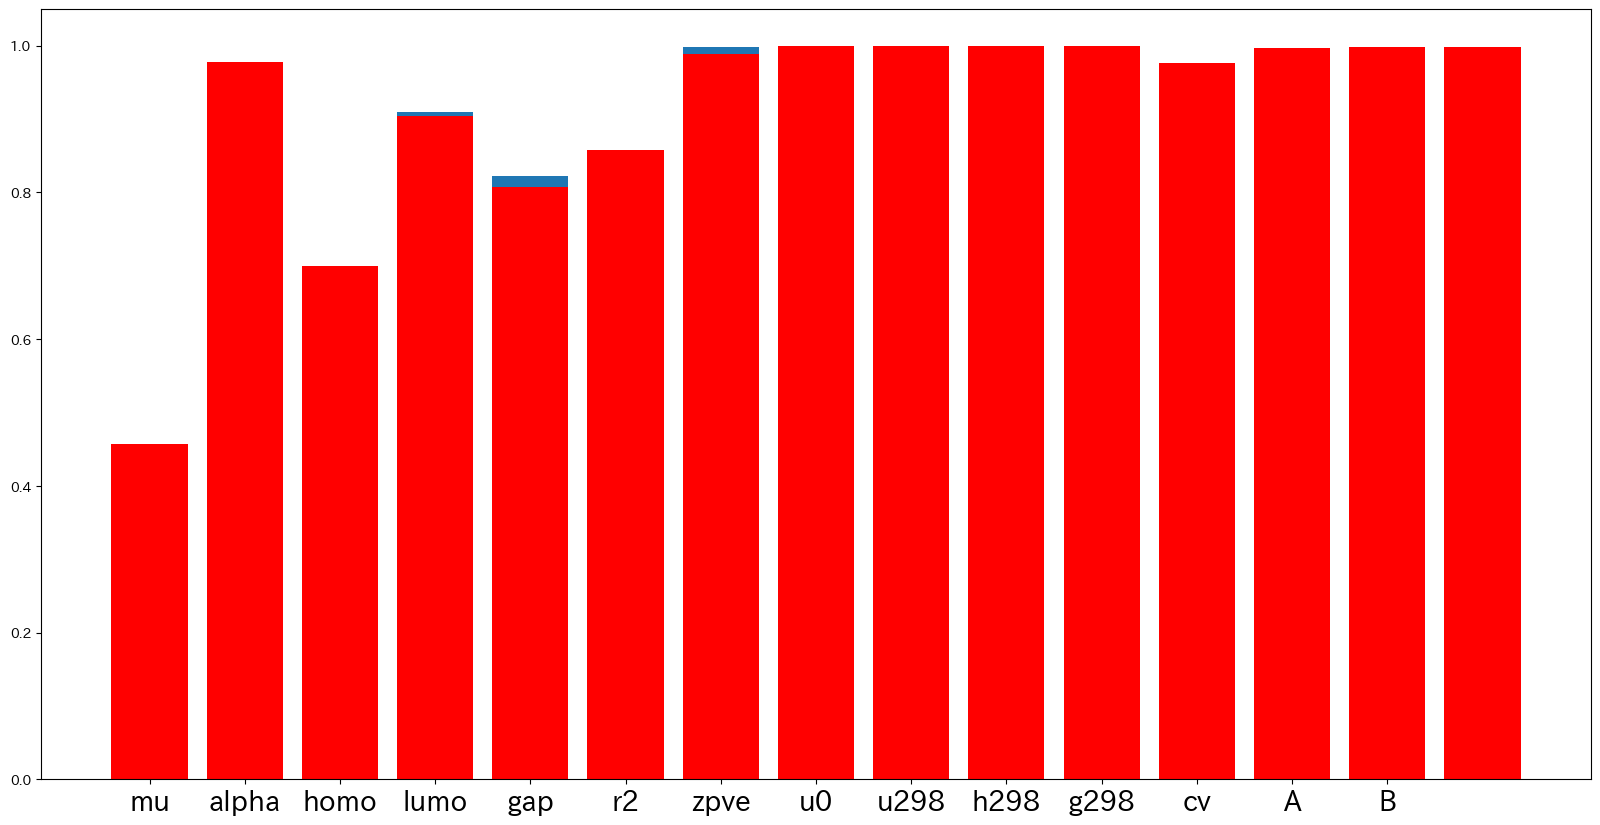

In [50]:
results_all = glob.glob("./results/honban/*/GCN_without_atomic_number")
r2_dict = {}
for result in results_all:
    target = result.split("/")[-2]
    with open(result, "rb") as f:
        result_pickle = pickle.load(f)
        r2 = [result["valid_R2"] for result in result_pickle["results"]]
        r2_max = max(r2)
        r2_dict[target] = r2_max

xbar = [i for i in range(len(results_all))]
labels = r2_dict.keys()
plt.figure(figsize=[20,10])
plt.bar(xbar, r2_dict.values())
plt.xticks(xbar, labels=labels, fontsize=20)

results_all = glob.glob("./results/honban/*/GCN_all")
r2_dict = {}
for result in results_all:
    target = result.split("/")[-2]
    with open(result, "rb") as f:
        result_pickle = pickle.load(f)
        r2 = [result["valid_R2"] for result in result_pickle["results"]]
        r2_max = max(r2)
        r2_dict[target] = r2_max

xbar = [i for i in range(len(results_all))]
labels = r2_dict.keys()
plt.bar(xbar, r2_dict.values(), color="red")
plt.show()


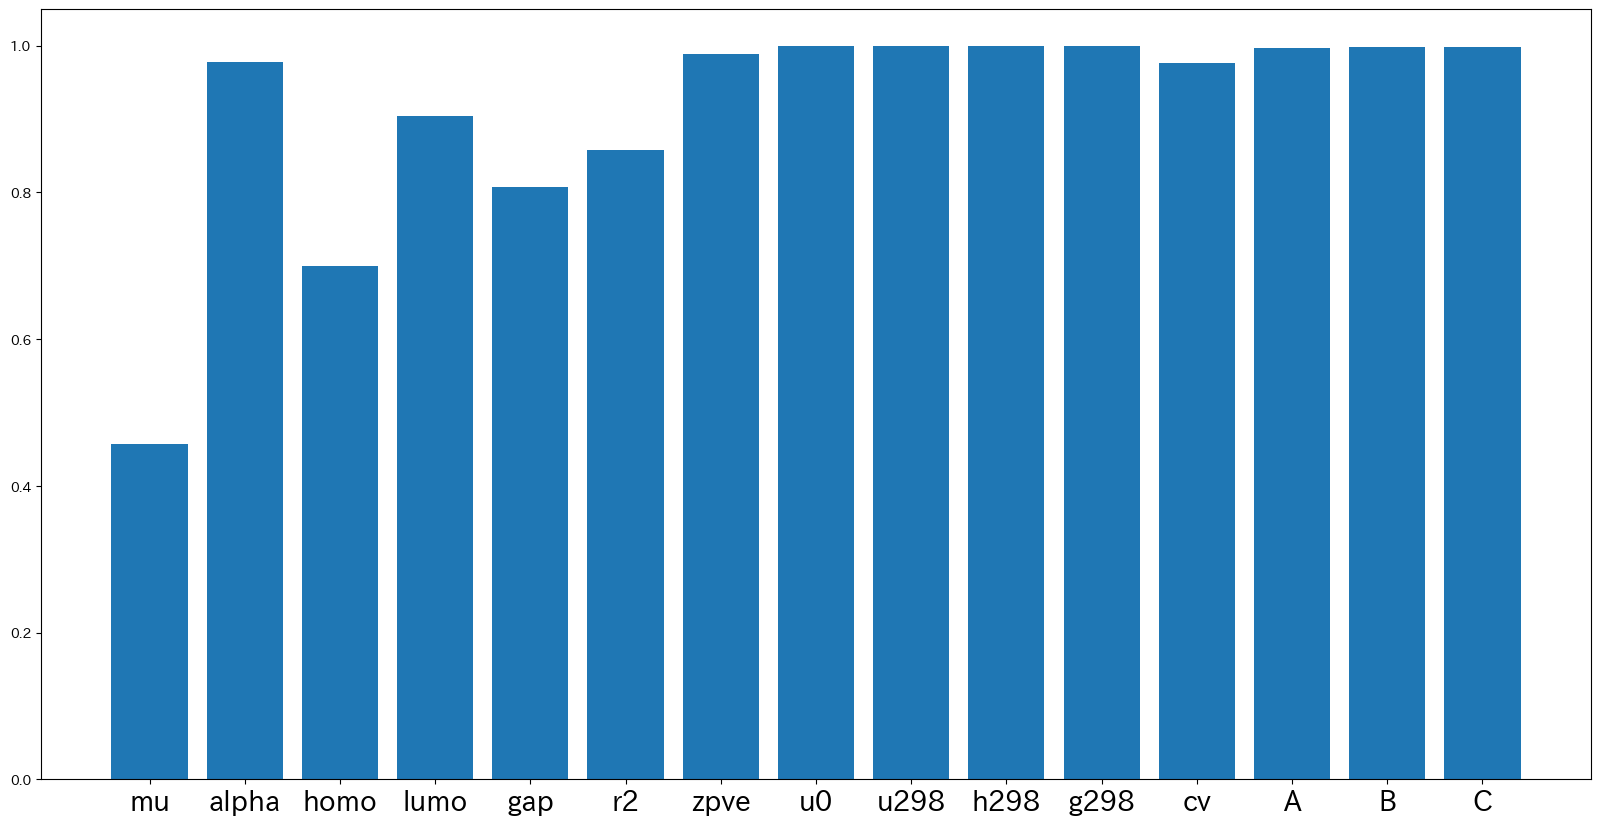

In [45]:
results_all = glob.glob("./results/honban/*/GCN_all")
r2_dict = {}
for result in results_all:
    target = result.split("/")[-2]
    with open(result, "rb") as f:
        result_pickle = pickle.load(f)
        r2 = [result["valid_R2"] for result in result_pickle["results"]]
        r2_max = max(r2)
        r2_dict[target] = r2_max

xbar = [i for i in range(len(results_all))]
labels = r2_dict.keys()
plt.figure(figsize=[20,10])
plt.bar(xbar, r2_dict.values())
plt.xticks(xbar, labels=labels, fontsize=20)
plt.show()
        

In [44]:
files = glob.glob("./results/1031/GCN*")
files = [file for file in files if not file.endswith("model")]
result_list = []
labels = [file.split("_")[1] for file in files]
labels[0] = "all"

for file in files:
    with open(file, "rb") as f:
        result = pickle.load(f)
        result = [i["valid_loss"] for i in result["results"]]
        label = file.split("_")[1]
        result_best = max(result)
    result_list.append(result_best)
plt.bar([i for i in range(len(files))], result_list)


IndexError: list assignment index out of range

In [ ]:
files = [file for file in glob.glob("./results/1031/*") if not file.endswith("model")]
bestscore = []
for file in files:
    with open(file, "rb") as f:
        result = pickle.load(f)
    best = min([r["valid_loss"]for r in result["results"]])
    bestscore.append({"name":file.split("_")[-1], "best":best})
bestscore[0]["name"] = "全て"
xbar = [i for i in range(len(files))]
labels = ["全て","原子番号","芳香性", "sp混成", "sp2混成", "sp3混成", "水素原子数", "形式電荷", "原子価", "隣接原子数"]
plt.figure(figsize=[20,10])
plt.bar(xbar, [score["best"] for score in bestscore])
plt.xticks(xbar, labels=labels, fontsize=20)
plt.xlabel("記述子", fontsize=30)
plt.ylabel("RMSE", fontsize=30)
plt.show()

In [ ]:
files = [file for file in glob.glob("./results/1031/*") if not file.endswith("model")]
bestscore = []
for file in files:
    with open(file, "rb") as f:
        result = pickle.load(f)
    best = min([r["train_loss"]for r in result["results"]])
    bestscore.append({"name":file.split("_")[-1], "best":best})
bestscore[0]["name"] = "全て"
xbar = [i for i in range(len(files))]
labels = ["全て","原子番号","芳香性", "sp混成", "sp2混成", "sp3混成", "水素原子数", "形式電荷", "原子価", "隣接原子数"]
plt.figure(figsize=[20,10])
plt.bar(xbar, [score["best"] for score in bestscore])
plt.xticks(xbar, labels=[score["name"] for score in bestscore], fontsize=20)
plt.xlabel("記述子", fontsize=30)
plt.ylabel("RMSE", fontsize=30)
plt.show()

x: ノード特徴量

y: 正解ラベル

pos: 原子の座標

edge_index: エッジインデックス

edge_attr: エッジ特徴量(使えん)

ノード特徴量
type_idx: 原子の種類 
aromatic: 芳香性
sp: sp混成
sp2: sp2混成
sp3: sp3混成

In [ ]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from torch_geometric.utils import to_networkx

data = dataset[7]
graph = to_networkx(data)
position = nx.spring_layout(graph)

#原子番号追加
elements = {
    1:"H",
    2:"He",
    3:"Li",
    4:"Be",
    5:"B",
    6:"C",
    7:"N",
    8:"O",
    9:"F"
}
atom_labels = {}
for i in range(data.num_nodes):
    atomic_num = int(data.x[i][0])
    atom_label = elements[atomic_num]
    atom_labels[i] = atom_label


pagerank = networkx.pagerank(graph) #pagerankはノードの中心性(重要性の指標)
pagerank_max = np.array(list(pagerank.values())).max()

#可視化する時のノード位置
draw_position = networkx.spring_layout(graph,seed=0)

plt.figure(figsize=(10,10))

networkx.draw_networkx_nodes(graph,
                            draw_position,
                            node_size=[v / pagerank_max * 1000 for v in pagerank.values()]
                            )

networkx.draw_networkx_edges(graph, draw_position, arrowstyle='-', alpha=0.2)
networkx.draw_networkx_labels(graph, draw_position, atom_labels, font_size=10)
plt.show()

In [ ]:
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt

# define the smiles string and covert it into a molecule sturcture ------------
smiles = 'CCO'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# define the function for coverting rdkit object to networkx object -----------     
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G

# conver rdkit object to networkx object --------------------------------------
graph = mol_to_nx(mol)

atoms = nx.get_node_attributes(graph, 'atom_symbol')

color_map = {'C': 'cyan',
             'O': 'red',
             'N': 'magenta',
             "H": "gray"}  

caffeine_colors = []
for idx in graph.nodes():
    if (graph.nodes[idx]['atom_symbol'] in color_map):
        caffeine_colors.append(color_map[graph.nodes[idx]['atom_symbol']])
    else:
        caffeine_colors.append('gray')
    
nx.draw(graph,
        labels=atoms,
        with_labels = True,
        node_color=caffeine_colors,
        node_size=800)

plt.show()

# print out the adjacency matrix ---------------------------------------------- 
matrix = nx.to_numpy_matrix(graph)
print(matrix)